# Getting Started with ML Training in XNAT

This notebook demonstrates the recommended practices for data management with XNAT and implements a basic machine learning training and evaulation workflow. 

For this demonstration, we training EfficientNet-B0 on BIRADS labeled mammograms to perform multilabel classification and evaluate its performance. 

This notebook is divided into 5 sections. 
#### Topic Covered
1. Setting up your Jupyter Environment
2. Understanding XNAT's Data Structure & the XNATpy SDK
3. Data Pulling & Filtering
4. Data Exploration, Preparation, & Train/Val/Test Splits
5. Running Model Training
6. Saving, Loading, & Evaluating the Model

<div style="background-color: #e7f3fe; border-left: 4px solid #2196F3; padding: 12px; margin: 10px 0;">
<strong>📌 Prerequisites</strong><br>
Before starting, ensure you have:
<ul>
<li>A reachable XNAT server URL</li>
<li>Credentials with appropriate project permissions</li>
<li><code>xnat</code> (xnatpy) and optionally <code>pydicom</code> installed</li>
</ul>
</div>

## 1. Setting up your Jupyter Environment

### 1.1 Installing Imports

Before we begin installing imports, we can see that a large number of common libraries are already installed for us!

In [1]:
# Here we can take a quick look at how many packages come pre-installed in the environment
!(conda list | head -10) 2>/dev/null && echo "" && echo "Found $(conda list | tail -n +4 | wc -l) packages in your environment!"

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
aiohappyeyeballs          2.6.1                    pypi_0    pypi
aiohttp                   3.12.15                  pypi_0    pypi
aiosignal                 1.4.0                    pypi_0    pypi
alabaster                 1.0.0                    pypi_0    pypi
alembic                   1.16.5                   pypi_0    pypi

Found 474 packages in your environment!


In [2]:
# Standard package & local utility imports
import os
import logging
import xnat
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path
from rich.tree import Tree
from rich import print
from requests.auth import HTTPBasicAuth
from collections import Counter
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from torchvision import models
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

# Local imports from our utility scripts
from src.utils.directory_tree import show_directory_tree
from src.utils.torch_data_loading import load_dicom_data_with_logging
from src.utils.data_handling import fetch_xnat_metadata
from src.utils.data_filtering_dash import data_filter_dashboard
from src.models.efficientnet import create_efficientnet_b0
from src.utils.model_evaluation import (
    plot_precision_recall_curves,
    plot_class_metrics_bar,
    plot_confidence_distribution,
)
from src.utils.training_runs import create_training_run, save_training_run
from src.utils.ml_eval_dash import ml_evaluation_dashboard

### 1.2 Initiating Logging 

After imports, we highly recommend initializing log tracking for tracking errors & unexpected outcomes.

In [3]:
# Create our log directory
Path.mkdir(Path('logs'), exist_ok=True)

logging.basicConfig(
    filename=f"logs/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# First log
logging.info("Logging initiatated...")

### 1.3 GPU Check
Now that our logging is initialized, let's check that our environment is GPU enabled.

In [4]:
# Here we create a small function to check our GPU status & log it
def check_gpu_status() -> torch.device:
      """Basic fn for checking what is available in user's env."""
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      cuda_available = torch.cuda.is_available()
      cuda_version = torch.version.cuda
      gpu_count = torch.cuda.device_count()
      gpu_name = torch.cuda.get_device_name(0) if cuda_available else "N/A"

      logging.info(f"Device: {device}")
      logging.info(f"CUDA available: {cuda_available}")
      logging.info(f"CUDA version: {cuda_version}")
      logging.info(f"GPU count: {gpu_count}")
      logging.info(f"GPU name: {gpu_name}")

      return device

In [5]:
# Calling our fn
device = check_gpu_status()

## 2. Understanding XNAT's Data Structure & the XNATpy SDK

### 2.1 Exploring the Mounted Data Directory

In this first section, we explore how we can directly interact with our mounted project data!

This will allow you to interact with your data in the same manner as you would if it was available locally!

In [6]:
# Here is a quick example of looking at our mounted data
for i, (root, dirs, files) in enumerate(os.walk("/data")):
  print(root)
  dirs[:] = dirs[:5]
  if i >= 7:
      break

/data

/data/projects

/data/projects/InBreastProject

/data/projects/InBreastProject/experiments

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734/SCANS

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734/SCANS/1_2_826_0_1_3680043_8_498_69195413700
476430552174544204581670404

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734/SCANS/1_2_826_0_1_3680043_8_498_69195413700
476430552174544204581670404/secondary

In [7]:
# Here we use a custom function for better visualization of our data directory
show_directory_tree(
  "/data",
  max_depth=8,
  max_items=2,
  max_files=3,
  depth_labels={
      1: "Project Label",
      3: "Experiment Label",
      5: "Scan Number",
  }
)

📁 /data
└── 📁 projects
    └── 📁 InBreastProject (Project Label)
        └── 📁 experiments
            ├── 📁 20586908_BIRADS_2_1158302830 (Experiment Label)
            │   └── 📁 SCANS
            │       └── 📁 1_2_826_0_1_3680043_8_498_10675674632970931711656630713501244231 (Scan Number)
            │           └── 📁 secondary
            │               ├── 📄 20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm
            │               └── 📄 
            │                   scan_1_2_826_0_1_3680043_8_498_10675674632970931711656630713501244231_secondary_cat
            │                   alog.xml
            ├── 📁 20586908_BIRADS_2_1554025637 (Experiment Label)
            │   └── 📁 SCANS
            │       └── 📁 1_2_826_0_1_3680043_8_498_98752643858555190245490297679306193402 (Scan Number)
            │           └── 📁 secondary
            │               ├── 📄 20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm
            │               └── 📄 
            │                   scan_1_2_826_0_1_3680043_8_498_98752643858555190245490297679306193402_secondary_cat
            │                   alog.xml
            └── ... and more directories

### 2.2 Understanding the XNATpy SDK

Now let's explore how XNATpy can make working with XNAT Data more efficient!

XNAT's Jupyter notebooks come pre-configured with your user credentials as Env variables!
    
  - `XNAT_HOST`
  - `XNAT_USER`
  - `XNAT_PASS`

#### Connecting to XNAT & Using XNATpy

Using the pre-configured Env Variables, we can quickly establish a connection to XNAT. 


In [8]:
# Assign & Call Env variables  
host = os.environ['XNAT_HOST']
username = os.environ['XNAT_USER']
password = os.environ['XNAT_PASS']

# Establish our connection to XNAT
connection = xnat.connect(
    host,
    user=os.environ['XNAT_USER'],
    password=os.environ['XNAT_PASS']
)

[WARNING] Detected a redirect from https://tap.embarklabs.ai to https://tap.embarklabs.ai:443/, using https://tap.embarklabs.ai:443/ from now on
[WARNING] Found an unsupported version (1.9.3), trying 1.7 compatible model builder
Exception in thread XNATpyKeepAliveThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/http/client.py", line 1390, in getresponse
    response.begin()
  File "/opt/conda/lib/python3.11/http/client.py", line 325, in begin


<!-- Tip (green) -->
<div style="background-color: #d4edda; border-left: 4px solid #28a745; padding: 12px; margin: 10px 0;">
<strong>❗ Must Know ❗</strong><br>
Though the Env Variable are named "XNAT_USER" & "XNAT_PASS", these <b> are not</b> your username or password! 
<br>These Env Variables store your user <b>Alias</b> and <b>Alias Token</b> which are utilized for establishing your connection to XNAT. 
</div>

Now that a connection is established, we can test our connection by finding our project!

In [9]:
# Check that our project exists
PROJECT_ID = "InBreastProject"
if PROJECT_ID not in connection.projects:
    raise ValueError(
        f"Project '{PROJECT_ID}' not found on this XNAT server."
        f"Available projects: {list(connection.projects.keys())}"
    )
project = connection.projects[PROJECT_ID]
print(f"{project.name} project found!")

# Check our experiments with our DICOMs exist.
print(f"Number of experiments found: {len(project.experiments)}")

InBreastDataset project found!

Number of experiments found: 410

Here are a few more quick ways to use XNATpy to interact with our data!

In [10]:
# Get an experiment from the project
experiments = project.experiments
experiment = experiments[0]
print(f"Experiments in Project: {len(experiments)}")


# Get a scan (DICOM) from an experiment
scans = experiment.scans
print(f"Scans in Experiment: {len(scans)}")

# Get DICOM from scan
# print(scans[0].resources['secondary'])


Experiments in Project: 410

Scans in Experiment: 1

<!-- Success/Tip (green) -->
<div style="background-color: #d4edda; border-left: 4px solid #28a745; padding: 12px; margin: 10px 0;">
<strong>💡 Tip</strong><br>
XNATpy can be used across <b>all projects</b> we have access to in order to create powerful tools for interacting and manipulating data. 
</div>

<!-- Warning (yellow) -->
<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 12px; margin: 10px 0;">
<strong>❓ Why use XNATpy when our data is mounted ❓</strong><br>
  -1) XNATpy provides a quick and efficient way to parse and direct DICOM metadata.<br>
  -2) It can be used to obtain the mounted path for objects in XNAT!<br>
  -3) Provides a unified method for interacting with XNAT data both on XNAT and on your local machine.
</div>

## 3. Data Pulling & Filtering

Now that we have seen how to use XNATpy, let's see how it can help us interact with our data.

The <code>fetch_xnat_metadata</code> function shown below utilizes XNATpy to efficiently pull demographic and scan metadata directly from the XNAT server, without needing to parse DICOM files on disk.

### 3.1 Creating a Dataframe

In [11]:
# Here we are creating a list of PROJECT_IDs from which to pull data
PROJECTS_LIST = ["InBreastProject","RIDER-LUNG-CT", "NSCLC_RADIOGENOMICS", "NSCLC_RADIOMICS"]


# We pass our existing connection to our function 
meta_df = fetch_xnat_metadata(
    project_ids=PROJECTS_LIST,
    connection=connection, 
    save_csv=True,  #  For multiple runs, we recommend caching your dataset
    csv_filename="xnat_metadata2", 
)

print(f"Metadata rows: {len(meta_df)}")
print(f"Projects included: {meta_df['project_name'].unique().tolist()}")
meta_df.head()

Loading cached metadata from: logs/saved_df/xnat_metadata2.csv


Metadata rows: 3090

Projects included: ['InBreastDataset', 'Rider Lung CT', 'NSCLC Radiogenomics', 'NSCLC Radiomics']

,project_id,project_name,subject_id,subject_label,gender,age,handedness,experiment_id,experiment_label,experiment_date,...,manufacturer_model_name,station_name,software_versions,series_description,series_number,acquisition_number,instance_number,patient_position,image_orientation_patient,body_part_examined
0,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00414,20587994_BIRADS_6_2944864255,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00434,20588020_BIRADS_2_3396612429,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00457,20588046_BIRADS_6_2583559448,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00477,20588072_BIRADS_2_2873555748,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,InBreastProject,InBreastDataset,TAP_S00002,036aff49b8ac84f0,NaN,NaN,NaN,TAP_E00419,20588654_BIRADS_2_1873531261,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Filtering and Exploring the Metadata

Use the interactive dashboard below to filter the metadata by various attributes such as project, modality, image dimensions, and more. The dashboard will display distribution charts and allow you to export filtered subsets.

In [12]:
# Create the filter dashboard
dashboard = data_filter_dashboard(
    meta_df,
    on_filter_callback=lambda df: None,
)

dashboard

<!-- Warning (yellow) -->
<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 12px; margin: 10px 0;">
<strong>⚠️ Notice</strong><br>
You will notice that some of this metadata may be missing. As de-identified datasets, many of these headers have been redacted!
</div>

In [16]:
# Get the currently filtered DataFrame (updates with every filter change):
subset_df = dashboard.get_filtered_df()

# Get the last exported DataFrame (set when you click "Export CSV"):
subset_df = dashboard.get_exported_df()

print(f"Working with {len(subset_df)} records")

dataset_dir = Path("logs/datasets")
dataset_dir.mkdir(parents=True, exist_ok=True)

# Create a timestamped filename for the dataset
dataset_csv_path = dataset_dir / f"training_subset_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
subset_df.to_csv(dataset_csv_path, index=False)
print(f"Saved training dataset to: {dataset_csv_path}")

Working with 410 records

Saved training dataset to: logs/datasets/training_subset_20251212_200019.csv

## 4. Data Exploration, Preparation, & Train/Val/Test Splits

Now that we have familizarized ourselves with our data, let's explore the dataset to uncover if there are any issues with our dataset. 

First, we will create a top level hyperparameter data structure for reusability. 

We strongly recommend using top level hyperparameter config structures! They facilitate conducting multiple training runs and with provenance tracking!

In [17]:
# Hyperparameters - all configurable settings for this training run
HPARAMS = {
    # Run identification
    "run_name": "EfficientNet-B0 with augmentation_dim112_e30",
    "model_name": "efficientnet_b0",
    "notes": "EfficientNet-B0 with data augmentation, dropout, and label smoothing. Img Dims [112,112], epochs: 30.",

    # Data source 
    "dataset_csv": str(dataset_csv_path),  

    # Data loading
    "batch_size": 32,
    "image_size": 112,
    "num_workers": 3,
    "val_split": 0.2,

    # Model architecture
    "dropout_rate": 0.3,
    "freeze_backbone": False,

    # Training
    "num_epochs": 30,
    "learning_rate": 1e-4,
    "weight_decay": 0.01,
    "label_smoothing": 0.1,

    # Scheduler
    "scheduler_factor": 0.5,
    "scheduler_patience": 5,

    # Early stopping
    "early_stop_patience": 10,
}

### 4.1 Data Loading & Training Configs

After confirming our data is available, we now need to pull the data and supply it to our model in the correct format. 

Here was are using Pytorch's DataLoaders to transform and organize our data before passing it to our model. 

In [18]:
# Here we load the data into our dataloader class using the filtered dataset
dataloaders = load_dicom_data_with_logging(
    HPARAMS["dataset_csv"],  # Note we are pulling from our filtered subset!
    batch_size=HPARAMS["batch_size"],
    num_workers=HPARAMS["num_workers"],
    val_split=HPARAMS["val_split"],
    image_size=HPARAMS["image_size"],
)

# We then separate the data into training and validate subsets
images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))

# And finally we check the dimensions of the data 
print(f"Training batch shape: {images_train.shape}")
print(f"Validation batch shape: {images_val.shape}")
print(f"Dataset source: {HPARAMS['dataset_csv']}")

Training batch shape: torch.Size([32, 3, 112, 112])

Validation batch shape: torch.Size([32, 3, 112, 112])

Dataset source: logs/datasets/training_subset_20251212_200019.csv

#### Checking our Labels
Next, we double check we have the correct number of labels. 

Our images are labeled according to BI-RADS assessment. We should see 6 unique labels from our dataset.

In [19]:
ys = torch.tensor(dataloaders['train'].dataset.labels)
print("Unique train labels:", sorted(ys.unique().tolist()))

Unique train labels:
[0, 1, 2, 3, 4, 5]

### 4.2 Visualizing Data from Dataloaders
With our data pulled and organized appropriately, let's pull a few examples and examine what our data looks like. 

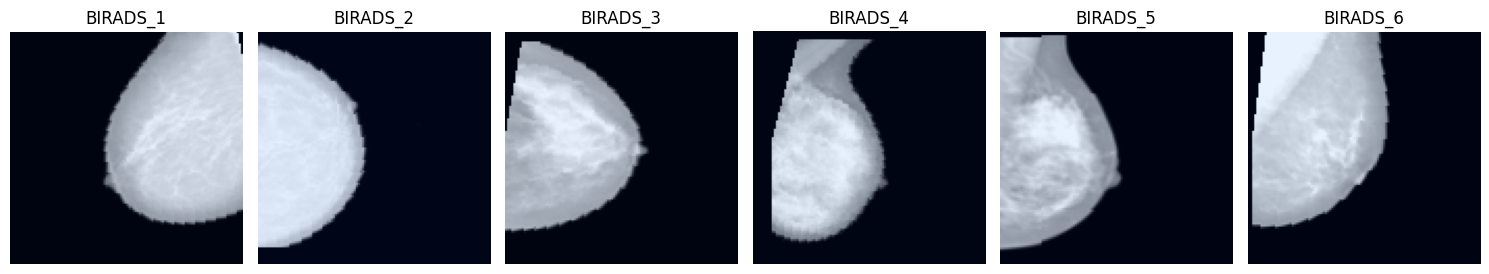

In [20]:
class_names = dataloaders['train'].dataset.classes
dataset = dataloaders['train'].dataset

# Build a mapping of class label -> first index with that label
label_to_idx = {}
for idx, label in enumerate(dataset.labels):
    if label not in label_to_idx:
        label_to_idx[label] = idx
    if len(label_to_idx) == len(class_names):
        break  # Found one of each, stop early

fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for ax, (label_value, class_name) in enumerate(zip(sorted(label_to_idx.keys()), class_names)):
    idx = label_to_idx[label_value]
    image, _ = dataset[idx]  # Directly index the dataset
    image = image.permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    axes[ax].imshow(image)
    axes[ax].set_title(class_name)
    axes[ax].axis('off')

plt.tight_layout()
plt.show()

### 4.3 Checking Class Distributions

After inspecting our data we found that the class distribution is unbalanced.

Now we will use the per-class distribution in the training and validation splits to mitigate this imbalance. 

We will also verify how the `WeightedRandomSampler` in our PyTorch `DataLoader` helps compensate for this imbalance. 

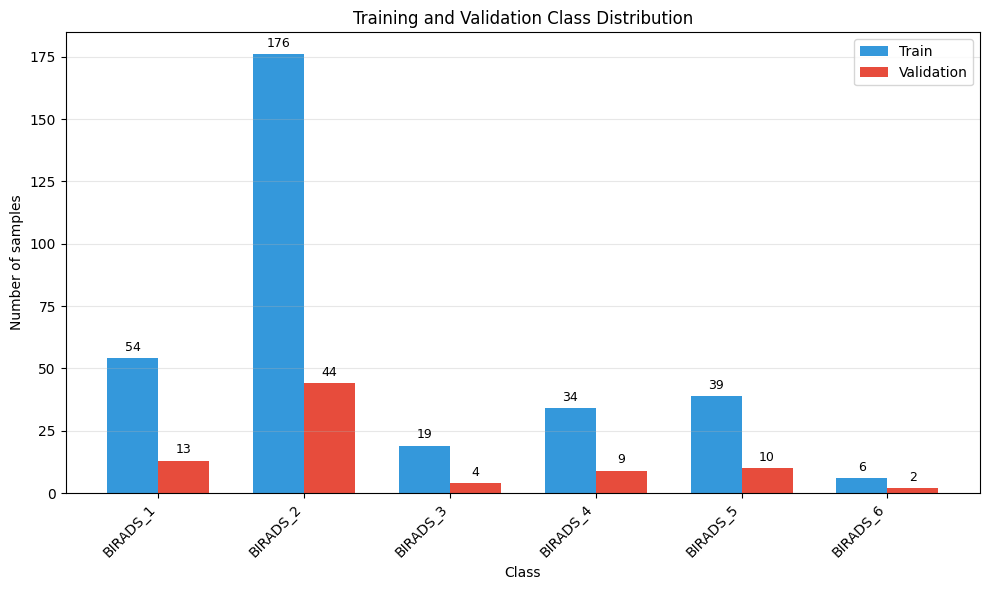

In [21]:
# --- 1. Raw label distribution (what's in the dataset) ---
train_labels = torch.tensor(dataloaders['train'].dataset.labels)
val_labels = torch.tensor(dataloaders['val'].dataset.labels)
class_names = dataloaders['train'].dataset.classes

train_counts = Counter(train_labels.tolist())
val_counts = Counter(val_labels.tolist())

# Plot combined train/val class distribution
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_names))
width = 0.35

train_values = [train_counts.get(i, 0) for i in range(len(class_names))]
val_values = [val_counts.get(i, 0) for i in range(len(class_names))]

bars_train = ax.bar(x - width/2, train_values, width, label='Train', color='#3498db')
bars_val = ax.bar(x + width/2, val_values, width, label='Validation', color='#e74c3c')

# Add counts above bars
for bar in bars_train:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars_val:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Class')
ax.set_ylabel('Number of samples')
ax.set_title('Training and Validation Class Distribution')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 4.4 Mitigating the Class Imbalance


We have now explored the class imbalance in our dataset, now let's ammend our Sampler in our Pytorch DataLoader in order to pull classes for training proportionally. 

Sampler mean weight per class:

0 -> BIRADS_1: mean weight = 0.0185

1 -> BIRADS_2: mean weight = 0.0057

2 -> BIRADS_3: mean weight = 0.0526

3 -> BIRADS_4: mean weight = 0.0294

4 -> BIRADS_5: mean weight = 0.0256

5 -> BIRADS_6: mean weight = 0.1667

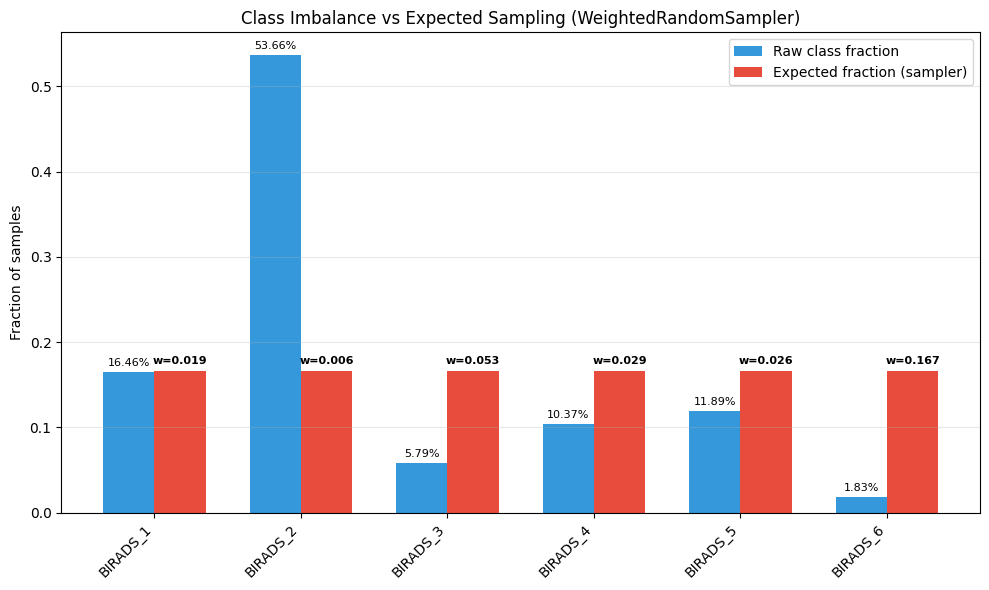

In [22]:
# =============================================================================
# Understanding the WeightedRandomSampler
# =============================================================================
# The WeightedRandomSampler addresses class imbalance by assigning higher sampling
# probabilities to underrepresented classes. Here's how it works:
#
# 1. For each class, we compute: weight = 1 / (number of samples in that class)
#    - Rare classes get HIGH weights (e.g., class with 10 samples -> weight = 0.1)
#    - Common classes get LOW weights (e.g., class with 100 samples -> weight = 0.01)
#
# 2. Each sample inherits the weight of its class
#
# 3. During training, samples are drawn with probability proportional to their weight
#    - This means rare class samples are picked MORE often
#    - Common class samples are picked LESS often
#
# 4. The result: each class contributes roughly equally to each epoch, regardless
#    of its original size in the dataset
#
# This helps prevent the model from being biased toward majority classes.
# =============================================================================

# --- Sampler weights and expected sampling distribution ---
sampler = dataloaders['train'].sampler

if hasattr(sampler, "weights"):
    w = sampler.weights.detach().cpu().numpy()
    y_np = train_labels.numpy()

    # Calculate mean weights per class
    mean_weights = {}
    for idx, name in enumerate(class_names):
        mask = (y_np == idx)
        if mask.any():
            mean_w = float(w[mask].mean())
            mean_weights[idx] = mean_w
        else:
            mean_weights[idx] = 0.0

    # Compute raw fraction vs expected fraction under the sampler
    total_samples = len(y_np)
    total_weight = w.sum()

    raw_frac = []
    expected_frac = []

    for idx in range(len(class_names)):
        mask = (y_np == idx)
        n_raw = mask.sum()
        raw_frac.append(n_raw / total_samples if total_samples > 0 else 0.0)

        w_sum = w[mask].sum()
        expected_frac.append(w_sum / total_weight if total_weight > 0 else 0.0)

    # Plot: raw vs expected sampling fraction with mean weights above bars
    fig, ax = plt.subplots(figsize=(10, 6))
    
    idxs = np.arange(len(class_names))
    width = 0.35

    bars_raw = ax.bar(idxs - width/2, raw_frac, width=width, label="Raw class fraction", color='#3498db')
    bars_expected = ax.bar(idxs + width/2, expected_frac, width=width, label="Expected fraction (sampler)", color='#e74c3c')
    
    # Add mean weights above the expected fraction bars
    for idx, bar in enumerate(bars_expected):
        height = bar.get_height()
        weight = mean_weights.get(idx, 0)
        ax.annotate(f'w={weight:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Add raw fractions above the raw bars
    for bar in bars_raw:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    ax.set_xticks(idxs)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_ylabel("Fraction of samples")
    ax.set_title("Class Imbalance vs Expected Sampling (WeightedRandomSampler)")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

else:
    print("\nNo WeightedRandomSampler detected on the training DataLoader.")

## 5. Running Model Training

Here we fine-tune an EfficientNet-B0 model on the DICOM data. As a parameter efficient model, EfficientNet-B0 is better suited for small datasets and reduces overfitting risk.

Key training features:
- **Dropout regularization**: 0.3 dropout implemented before classification layer
- **Label smoothing**: Implemented to prevent overconfident predictions
- **Weight decay**: AdamW optimizer with L2 regularization
- **Data augmentation**: Random crops, flips, rotations, and color jitter used in transformations

In [23]:
num_classes = len(dataloaders['train'].dataset.classes)
print(f"Detected {num_classes} classes:", dataloaders['train'].dataset.classes)

# Create EfficientNet-B0 with dropout regularization
model = create_efficientnet_b0(
    num_classes=num_classes,
    dropout_rate=HPARAMS["dropout_rate"],
    freeze_backbone=HPARAMS["freeze_backbone"],
)

print(f"Total parameters: {model.get_num_total_params():,}")
print(f"Trainable parameters: {model.get_num_trainable_params():,}")

# Use CrossEntropyLoss with label smoothing to prevent overconfident predictions
criterion = nn.CrossEntropyLoss(label_smoothing=HPARAMS["label_smoothing"])

# AdamW with weight decay for additional regularization
optimizer = optim.AdamW(
    model.parameters(),
    lr=HPARAMS["learning_rate"],
    weight_decay=HPARAMS["weight_decay"],
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=HPARAMS["scheduler_factor"],
    patience=HPARAMS["scheduler_patience"],
)

# Early stopping to prevent overfitting
best_val_loss = float('inf')
patience_counter = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_err": [],
    "val_err": [],
}

for epoch in range(HPARAMS["num_epochs"]):
    # ----- Train -----
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for xb, yb in dataloaders["train"]:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_total += yb.size(0)

    epoch_train_loss = running_loss / running_total
    epoch_train_err = 1.0 - (running_correct / running_total)

    # ----- Validation -----
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_running_total = 0

    with torch.no_grad():
        for xb, yb in dataloaders["val"]:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            val_running_correct += (preds == yb).sum().item()
            val_running_total += yb.size(0)

    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_err = 1.0 - (val_running_correct / val_running_total)

    history["train_loss"].append(epoch_train_loss)
    history["val_loss"].append(epoch_val_loss)
    history["train_err"].append(epoch_train_err)
    history["val_err"].append(epoch_val_err)

    scheduler.step(epoch_val_loss)
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # Save best model weights
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1

    print(
        f"Epoch {epoch+1}/{HPARAMS['num_epochs']} | "
        f"train_loss={epoch_train_loss:.4f}, val_loss={epoch_val_loss:.4f}, "
        f"train_err={epoch_train_err:.4f}, val_err={epoch_val_err:.4f}"
    )
    
    if patience_counter >= HPARAMS["early_stop_patience"]:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Load best model weights
if 'best_model_state' in dir():
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with val_loss={best_val_loss:.4f}")

Detected 6 classes:
['BIRADS_1', 'BIRADS_2', 'BIRADS_3', 'BIRADS_4', 'BIRADS_5', 'BIRADS_6']

Total parameters: 4,015,234

Trainable parameters: 4,015,234

Epoch 1/30 | train_loss=1.8128, val_loss=1.8726, train_err=0.8232, val_err=0.8902

Epoch 2/30 | train_loss=1.8090, val_loss=1.8480, train_err=0.8049, val_err=0.8902

Epoch 3/30 | train_loss=1.7655, val_loss=1.8144, train_err=0.7683, val_err=0.8780

Epoch 4/30 | train_loss=1.7651, val_loss=1.7920, train_err=0.7530, val_err=0.7927

Epoch 5/30 | train_loss=1.7549, val_loss=1.7989, train_err=0.7439, val_err=0.8415

Epoch 6/30 | train_loss=1.7112, val_loss=1.8197, train_err=0.7012, val_err=0.8049

Epoch 7/30 | train_loss=1.7268, val_loss=1.8384, train_err=0.7012, val_err=0.8171

Epoch 8/30 | train_loss=1.6780, val_loss=1.8524, train_err=0.6585, val_err=0.8902

Epoch 9/30 | train_loss=1.6423, val_loss=1.9382, train_err=0.6189, val_err=0.9146

Epoch 10/30 | train_loss=1.6103, val_loss=1.9173, train_err=0.6067, val_err=0.9268

Epoch 11/30 | train_loss=1.5743, val_loss=1.9177, train_err=0.5579, val_err=0.9390

Epoch 12/30 | train_loss=1.5885, val_loss=1.9963, train_err=0.5915, val_err=0.9146

Epoch 13/30 | train_loss=1.5896, val_loss=2.0057, train_err=0.6037, val_err=0.9390

Epoch 14/30 | train_loss=1.5912, val_loss=2.0023, train_err=0.6372, val_err=0.9268

Early stopping triggered after 14 epochs

Loaded best model with val_loss=1.7920

## 6. Saving, Loading, & Evaluating the Model

We now evaluate the fine-tuned model on the validation split using:
- Macro-averaged F1-score, precision, and recall
- Per-class classification report
- Loss and error-rate curves over epochs
- Confusion matrix with BI-RADS class labels on each axis


Macro precision: 0.0670

Macro recall:    0.1608

Macro F1-score:  0.0765

Per-class classification report (validation):

precision    recall  f1-score   support

    BIRADS_1       0.17      0.15      0.16        13
    BIRADS_2       0.00      0.00      0.00        44
    BIRADS_3       0.00      0.00      0.00         4
    BIRADS_4       0.07      0.11      0.08         9
    BIRADS_5       0.14      0.20      0.17        10
    BIRADS_6       0.03      0.50      0.05         2

    accuracy                           0.07        82
   macro avg       0.07      0.16      0.08        82
weighted avg       0.05      0.07      0.06        82

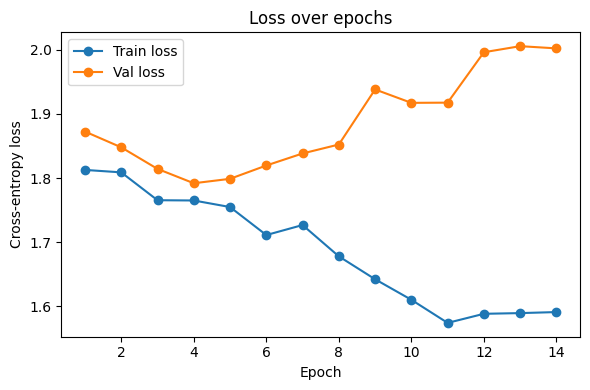

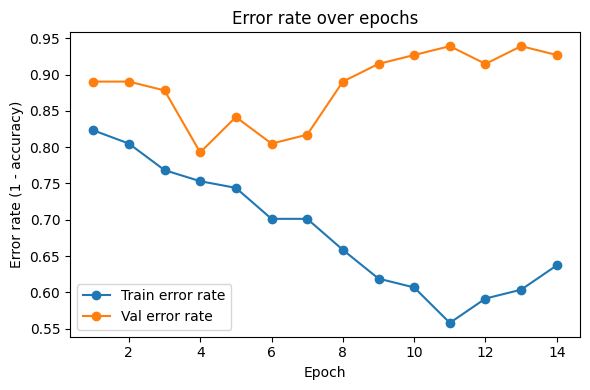

In [24]:
model.eval()
all_labels = []
all_preds = []
all_probs = []  # Store prediction probabilities for ROC/PR curves
all_images = []  # Store images for Grad-CAM visualization

with torch.no_grad():
    for xb, yb in dataloaders["val"]:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        all_images.extend(xb.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_images = np.array(all_images)

class_names = dataloaders["val"].dataset.classes

macro_precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
macro_recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"Macro precision: {macro_precision:.4f}")
print(f"Macro recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}\n")

print("Per-class classification report (validation):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# ---- Loss and error-rate curves ----
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_loss"], marker="o", label="Train loss")
plt.plot(epochs, history["val_loss"], marker="o", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Loss over epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_err"], marker="o", label="Train error rate")
plt.plot(epochs, history["val_err"], marker="o", label="Val error rate")
plt.xlabel("Epoch")
plt.ylabel("Error rate (1 - accuracy)")
plt.title("Error rate over epochs")
plt.legend()
plt.tight_layout()
plt.show()

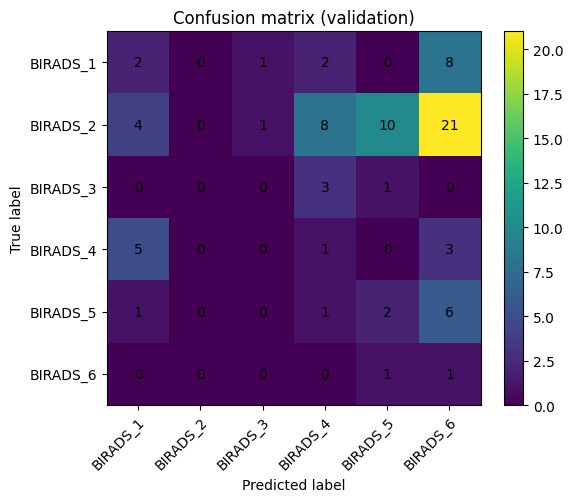

In [25]:
# ---- Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion matrix (validation)",
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with the count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            int(cm[i, j]),
            ha="center",
            va="center",
        )

plt.tight_layout()
plt.show()

### 6.1 Advanced Evaluation Visualizations

Beyond basic metrics, we examine model performance through:
- **ROC Curves**: Trade-off between sensitivity and specificity per class
- **Precision-Recall Curves**: Especially informative for imbalanced classes
- **Per-Class Metrics**: Side-by-side comparison of F1, precision, and recall
- **Confidence Distribution**: How confident is the model on correct vs incorrect predictions?
- **Grad-CAM**: Visual explanations of what regions drive predictions

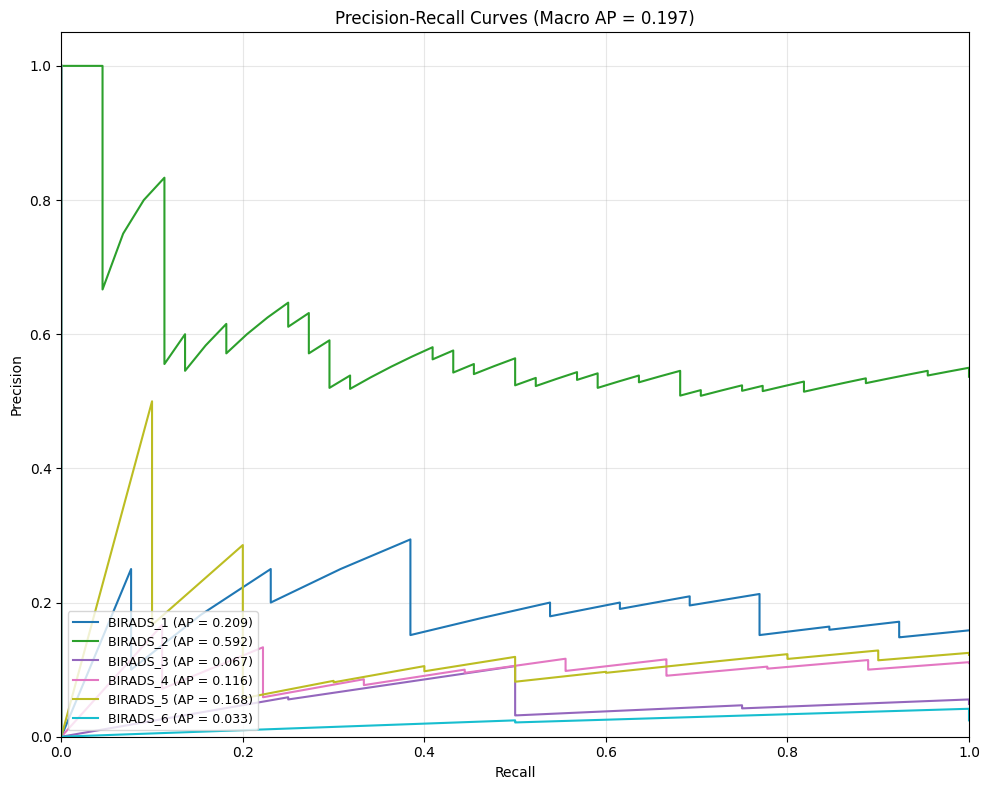

In [26]:
# Precision-Recall Curves - more informative than ROC for imbalanced datasets
fig_pr = plot_precision_recall_curves(all_labels, all_probs, class_names)
plt.show()

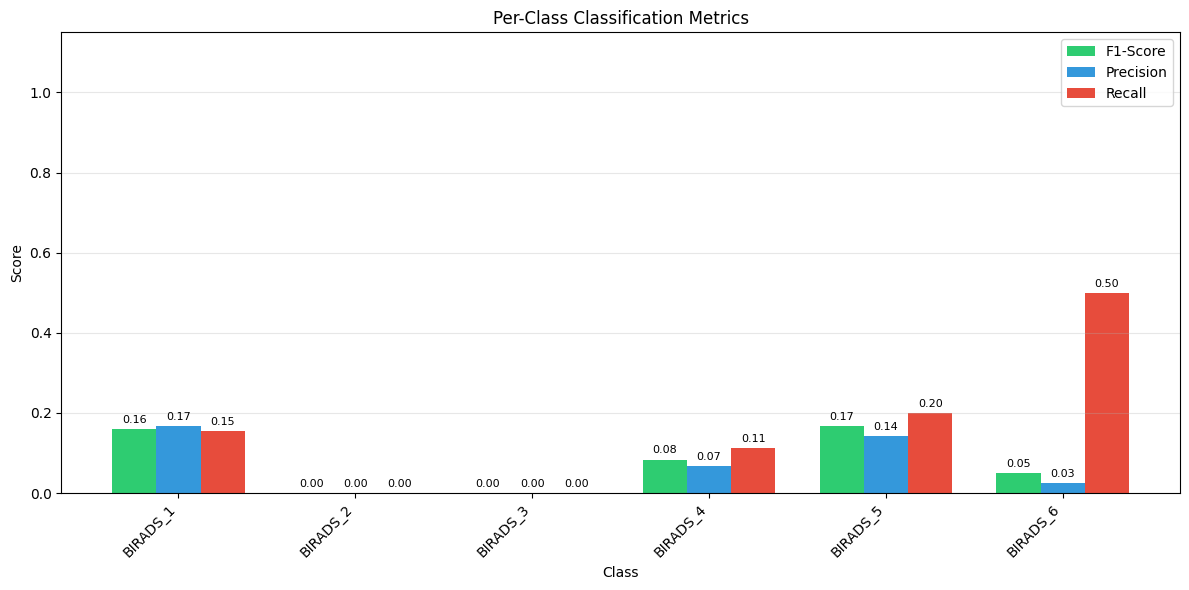

In [27]:
# Per-class metrics comparison - identify which classes the model struggles with
fig_metrics = plot_class_metrics_bar(all_labels, all_preds, class_names)
plt.show()

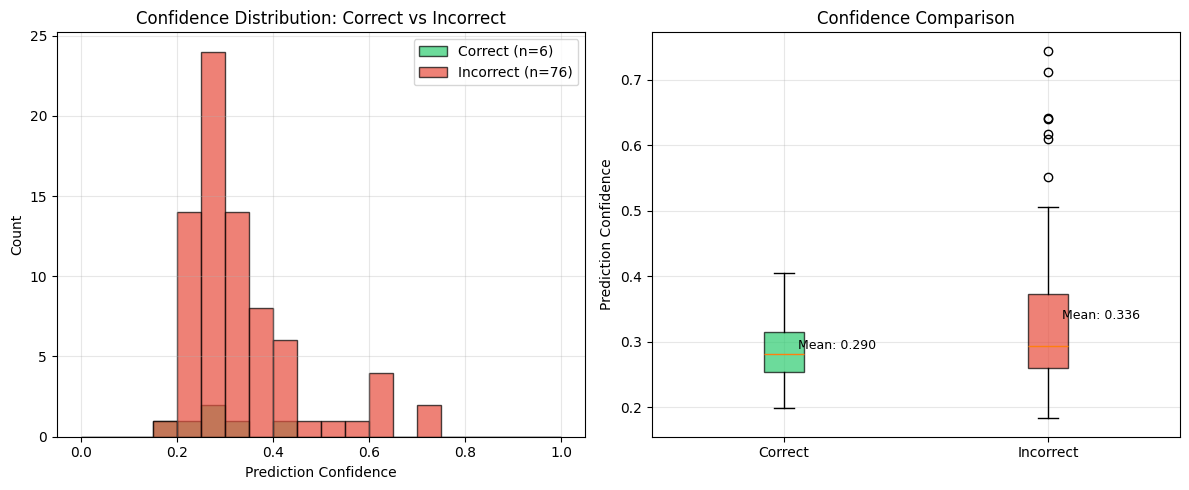

In [28]:
# Confidence distribution - compare model confidence on correct vs incorrect predictions
fig_conf = plot_confidence_distribution(all_labels, all_preds, all_probs)
plt.show()

### 6.2 Save Training Run

Save all training data for later comparison with other runs. This allows you to:
- Compare different model architectures
- Compare different hyperparameter settings
- Track experiment history over time

In [29]:
# Create a training run with all the data needed for dashboards
run = create_training_run(
    run_name=HPARAMS["run_name"],
    model_name=HPARAMS["model_name"],
    history=history,
    labels=all_labels,
    preds=all_preds,
    probs=all_probs,
    class_names=class_names,
    images=all_images,  # Optional: set to None to save disk space
    hyperparameters=HPARAMS,  # Save all hyperparameters
    notes=HPARAMS["notes"],
)

# Save the run to disk
save_training_run(
    run,
    save_dir="training_runs",
    save_images=True,  
    save_model=True,  
)

Saved training run 'EfficientNet-B0 with augmentation_dim112_e30' to training_runs/20251212_201421


PosixPath('training_runs/20251212_201421')

### 6.3 Compare Training Runs

Use this dashboard to compare saved training runs. You can:
- Select different runs from the dropdown
- View summary metrics, loss curves, ROC curves, and confusion matrices
- Compare all runs side-by-side

In [31]:
# Create and display the dashboard
dashboard = ml_evaluation_dashboard("training_runs")
dashboard

# Access selected runs programmatically
# selected_run_ids = dashboard.get_selected_runs()
# loaded_runs = dashboard.get_loaded_runs()